# Neural network in pure JAX

<span style="font-size: 90%">
This notebook:

1. generates input data `xs` and target outputs `y0s` based on a cubic polynomial.  
2. It defines a neural network (`network_forward`) with parameters initialized for a 1-10-10-1 architecture.  
3. The loss function (`loss_fn`) computes mean squared error between predictions and targets.  
4. Training is performed using gradient descent (`update_params` and `train_network`).  
5. Finally, it plots the original data and the neural network's predictions after training.

</span>

In [36]:
import jax.numpy as jnp
xs = jnp.arange(-1.0,1.0,2/20)
y0s=2*xs+1+2*xs**2+2*xs**3

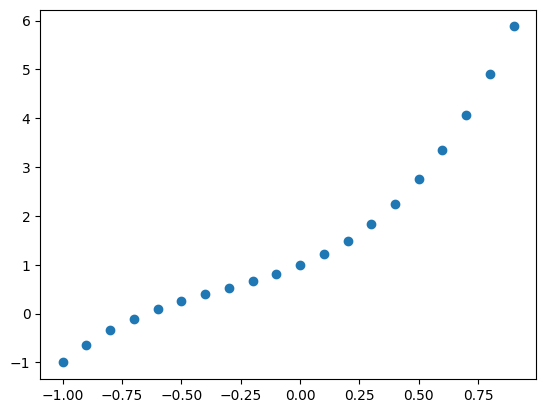

In [19]:
import matplotlib.pyplot as plt
plt.plot(xs, y0s, marker='o', linestyle='None')

Multilayer perceptron:

In [20]:
import jax
@jax.jit
def network_forward(xs, params):
    for i, [weigths, biases] in enumerate(params):
        xs = jnp.dot(xs, weigths) + biases
        # Apply activation except for the last layer
        if i < len(params) - 1:
            xs = jnp.tanh(xs)
        else:
            xs = xs
    return xs


Parameter initialization using jax pseudorandom number generator

In [21]:
import jax.random as random

key = random.PRNGKey(0)

def init_layer_params(input_size, output_size, key):
    k1, k2 = random.split(key)
    weights = random.normal(k1, (input_size, output_size))
    biases = random.normal(k2, (output_size,))
    return weights, biases

layer_sizes = [1, 10, 10, 1]
keys = random.split(key, num=len(layer_sizes)-1)
params = [init_layer_params(m, n, k) for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)]

Loss function, just in time compiled:

In [22]:
@jax.jit
def loss_fn(params, xs, y0s):
    ys_pred = network_forward(xs[:, None], params).flatten()
    return jnp.mean((y0s - ys_pred) ** 2)
print(loss_fn(params, xs, y0s))

8.352277


Subroutine to update the parameters:

In [38]:
@jax.jit
def update_params(params, xs, y0s, learning_rate=0.01):
    grads = jax.grad(loss_fn)(params, xs, y0s)
    new_params = []
    for p, g in zip(params, grads):
        new_p = (p[0] - learning_rate * g[0], p[1] - learning_rate * g[1])
        new_params.append(new_p)
    return new_params

Train the network using gradient decent:

In [25]:
@jax.jit
def train_network(params, xs, y0s, num_iterations=1000, learning_rate=0.01):
    def body_fun(i, val):
        params = val
        params = update_params(params, xs, y0s, learning_rate)
        return params

    params = jax.lax.fori_loop(0, num_iterations, body_fun, params)
    return params
params = train_network(params, xs, y0s, num_iterations=1000, learning_rate=0.04)

Plot fit curve overlaid with input data points:

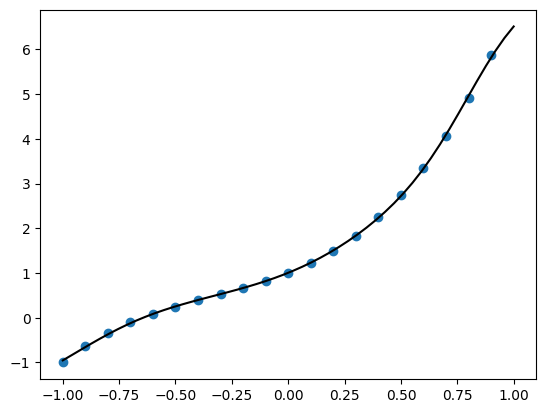

In [26]:
plt.plot(xs, y0s, marker='o', linestyle='None')
xs2 = jnp.linspace(-1,1,50)
plt.plot(xs2, network_forward(xs2[:, None], params).flatten(), linestyle='-', color='black', marker=None)
